# Предсказание вкуса и удоя молока коров 🥛 

**Описание проекта:** Молочное хозяйство «Вольный луг» хочет расширить поголовье стада коров. После заключения контракта с "ЭкоФермой" необходимо принимать объективные решения о покупке коро, а также управлять рисками.

**Цель проекта:** Разработка модели машинного обучения, которая поможет молочному хозяйству "Вольный луг" принимать соответствующие решения для сохранения качества молока и поддержания соответствующего планам его количества на основе предоставленных компанией "ЭкоФерма" данных.

**Ход исследования:**
- Подготовка данных: загрузка и изучение общей информации
- Предобработка данных: обработка пропущенных значений и дубликатов, корректировка типов данных, устранение проблем
- Исследовательский анализ данных: статистический анализ данных, исследование признаков, выводы о данных, улучшение данных
- Корреляционный анализ признаков в датасете: расчет коэффициентов корреляции признаков, диаграммы рассеяния, выводы о взаимосвязях данных
- Задача регрессии: обучение трех моделей линейной регрессии, анализ полученных результатов
- Задача классификаци: подготовка данных, обучение и анализ модели классификации
- Выводы

**Содержание**<a id='toc0_'></a>    
  
1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек](#toc1_1_)             
  1.2 [Используемые функции](#toc1_2_)                 
  1.3 [Загрузка данных и изучение общей информации](#toc1_3_) 
  
2. [Предобработка данных](#toc2_)         
  2.1 [Исследование пропусков в данных](#toc2_1_)    
  2.2 [Обработка явных и неявных дубликатов ](#toc2_2_)    
  2.3 [Преобразование данных в нужные типы](#toc2_3_)    
  
3. [Исследовательский анализ данных (EDA)](#toc3_)    
  3.1 [Статистический анализ признаков *ferma_main*](#toc3_1_)    
  3.2 [Статистический анализ признаков *ferma_dad*](#toc3_2_)     
  3.3 [Статистический анализ признаков *cow_buy*](#toc3_3_)     
  
4. [Корреляционный анализ признаков в датасете *ferma_main*](#toc4_)     
  4.1 [Расчет коэффициентов корреляции между признаками](#toc4_1_)     
  4.2 [Диаграммы рассеяния для признака *milk_yield*](#toc4_2_)        
  
5. [Задача регрессии](#toc5_)                     
  5.1 [Первая модель линейной регрессии ](#toc5_1_)                         
  5.2 [Вторая модель линейной регрессии ](#toc5_2_)                             
  5.3 [Третья модель линейной регрессии ](#toc5_3_)                        
  5.4 [Сравнение метрик и построение доверительного интервала для лучшей модели ](#toc5_4_)     
  5.5 [Прогноз удоя коров, рассматриваемых к покупке](#toc5_5_)     
   
6. [Задача классификации](#toc6_)            
  6.1 [Модель логистической регрессии ](#toc6_1_)                                           
  6.2 [Анализ модели логистической регрессии. Улучшение метрик ](#toc6_2_)                    
  6.3 [Предсказание вкуса молока коров, рассматриваемых к покупке](#toc6_3_)   

7. [Итоговые выводы](#toc7_)


## <a id='toc1_'></a> 1 Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a>1.1 Установка библиотек      [&#8593;](#toc0_)

In [1]:
%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from os import path
from prettytable import PrettyTable
from termcolor import colored

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    accuracy_score,
    recall_score,
    precision_score,
    r2_score,
    ConfusionMatrixDisplay,
    classification_report,
    PrecisionRecallDisplay)


### <a id='toc1_2_'></a>1.2 Используемые функции    [&#8593;](#toc0_)

In [3]:
RANDOM_STATE = 42
pd.options.display.float_format = '{:.2f}'.format

In [4]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first',sparse_output=False)

In [5]:
def to_numeric_columns(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    for col in cols:
        try:
            df[col] = df[col].astype('float32')
        except:
            continue
        
    return df

In [6]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [7]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()


In [8]:
def plot_pie_chart(series: pd.Series, title: str) -> None:
    table_1 = series.value_counts()
    data, labels = table_1.values, table_1.index
    plt.pie(data, labels=labels, autopct='%.0f%%')
    plt.title(title)
    plt.show()

In [9]:
def addlabels(data,x,y) -> None:
    for i in range(len(data)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

In [10]:
def proc_split(X: pd.DataFrame,
                      y: pd.DataFrame,
                      num_cols: list[str],
                      cat_cols: list[str],
                      stratify_by = None
                      ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=stratify_by)
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
    
    X_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_cols]), columns=encoder.get_feature_names_out())
    X_test_ohe = pd.DataFrame(encoder.transform(X_test[cat_cols]), columns=encoder.get_feature_names_out())
    
    X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
    X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)
    
    X_train = X_train.sort_index(axis=1)
    X_test = X_test.sort_index(axis=1)
    
    return X_train, X_test, y_train, y_test

In [11]:
def metrics(y_true, y_pred) -> list[str]:
    return ([
              f'{r2_score(y_true, y_pred):.5f}',
              f'{mean_absolute_error(y_true, y_pred):.5f}',
              f'{mean_squared_error(y_true, y_pred):.5f}',
              f'{root_mean_squared_error(y_true, y_pred):.5f}']
    )

### <a id='toc1_3_'></a>1.3 Загрузка данных и изучение общей информации   [&#8593;](#toc0_)

In [12]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', index_col='id', decimal=',')
ferma_main.head()

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.07,вкусно,менее_2_лет


In [13]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 1 to 627
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Удой, кг                               634 non-null    int64  
 1   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 2   Сырой протеин, г                       634 non-null    int64  
 3   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 4   Порода                                 634 non-null    object 
 5   Тип пастбища                           634 non-null    object 
 6   порода папы_быка                       634 non-null    object 
 7   Жирность,%                             634 non-null    float64
 8   Белок,%                                634 non-null    float64
 9   Вкус молока                            634 non-null    object 
 10  Возраст                                634 non-null    object 
dtypes: flo

Данные на первый взгляд соответствуют введенным параметрам. Видим, что названия столбцов не соответствуют принятым нормам. Переименуем их:

In [14]:
ferma_main = ferma_main.rename(columns={
   'Удой, кг': 'milk_yield',
   'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
   'Сырой протеин, г': 'raw_protein',
   'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
   'Порода': 'breed',
   'Тип пастбища': 'pasture_type',
   'порода папы_быка': 'breed_of_dad',
   'Жирность,%': 'fat_content',
   'Белок,%': 'protein',
   'Вкус молока': 'milk_taste',
   'Возраст': 'age',}, 
    errors='raise'
)

ferma_main.head()

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.07,вкусно,менее_2_лет


Таким же образом исследуем два других дата-фрейма:

In [15]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', index_col='id', decimal=',')
ferma_dad.head()

,Имя Папы
id,
1,Буйный
2,Соловчик
3,Барин
4,Буйный
5,Барин


In [16]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 629
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Имя Папы  629 non-null    object
dtypes: object(1)
memory usage: 9.8+ KB


Так же поменяем название колонки:


In [17]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'dad_name'})
ferma_dad.head()

,dad_name
id,
1,Буйный
2,Соловчик
3,Барин
4,Буйный
5,Барин


In [18]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


In [19]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Переименуем столбцы:

In [20]:
cow_buy = cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'breed_of_dad',
    'Имя_папы': 'dad_name',
    'Текущая_жирность,%': 'fat_content',
    'Текущий_уровень_белок,%': 'protein',
    'Возраст': 'age'}
)
cow_buy.head()

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


Перейдем к предобработке данных.

## <a id='toc2_'></a> 2 Предобработка данных [&#8593;](#toc0_)

### <a id='toc2_1_'></a>2.1 Исследование пропусков в данных  [&#8593;](#toc0_)

In [21]:
print_nans_table(ferma_main)

+---------------------+---------------------------------+
|       Признаки      | Пропущенное количество значений |
+---------------------+---------------------------------+
|      milk_yield     |             0 (0.0%)            |
|   energy_feed_unit  |             0 (0.0%)            |
|     raw_protein     |             0 (0.0%)            |
| sugar_protein_ratio |             0 (0.0%)            |
|        breed        |             0 (0.0%)            |
|     pasture_type    |             0 (0.0%)            |
|     breed_of_dad    |             0 (0.0%)            |
|     fat_content     |             0 (0.0%)            |
|       protein       |             0 (0.0%)            |
|      milk_taste     |             0 (0.0%)            |
|         age         |             0 (0.0%)            |
+---------------------+---------------------------------+


Как мы видим, пропущенных значений в данном датафрейме нет. Проверим в остальных:

In [22]:
print_nans_table(ferma_dad)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
| dad_name |             0 (0.0%)            |
+----------+---------------------------------+


In [23]:
print_nans_table(cow_buy)

+--------------+---------------------------------+
|   Признаки   | Пропущенное количество значений |
+--------------+---------------------------------+
|    breed     |             0 (0.0%)            |
| pasture_type |             0 (0.0%)            |
| breed_of_dad |             0 (0.0%)            |
|   dad_name   |             0 (0.0%)            |
| fat_content  |             0 (0.0%)            |
|   protein    |             0 (0.0%)            |
|     age      |             0 (0.0%)            |
+--------------+---------------------------------+


В предоставленных данных нет пропусков, это говорит об ответственности людей, занимающихся ведением учета своих баз.

### <a id='toc2_2_'></a>2.2 Обработка явных и неявных дубликатов  [&#8593;](#toc0_)

1. Датафрейм *ferma_main*:

Приведем значения к нижнему регистру:

In [24]:
cols = ['breed', 'pasture_type', 'breed_of_dad', 'age']
for col in cols:
    ferma_main[col] = ferma_main[col].str.lower()

In [25]:
ferma_main.duplicated().sum()

5

Проверим, что это действительно полные дубликаты:

In [26]:
ferma_main.loc[ferma_main.duplicated(), :]

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
627,5970,14.40,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.08,не вкусно,более_2_лет
627,5970,14.40,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.08,не вкусно,более_2_лет
627,5970,14.40,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.08,не вкусно,более_2_лет
627,5970,14.40,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.08,не вкусно,более_2_лет
627,5970,14.40,1837,0.88,рефлешнсоверинг,холмистое,соверин,3.64,3.08,не вкусно,более_2_лет


Как мы видим, это действительно полные дубликаты, у них одинаковые *id*, а также остальные характеристики, поэтому удалим их.

In [27]:
ferma_main = ferma_main.drop_duplicates()

Удалили явные дубликаты. Проверим на неявные:

In [28]:
ferma_main['breed'].unique()

array(['вис бик айдиал', 'рефлешнсоверинг'], dtype=object)

In [29]:
ferma_main['pasture_type'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

Заменим одинаковы по смыслу значения:

In [30]:
ferma_main.loc[ferma_main['pasture_type']=='равнинные','pasture_type'] = 'равнинное'

In [31]:
ferma_main['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [32]:
ferma_main['breed_of_dad'].unique()

array(['айдиал', 'соверин', 'айдиалл'], dtype=object)

In [33]:
ferma_main.loc[ferma_main['breed_of_dad']=='айдиалл','breed_of_dad'] = 'айдиал'

In [34]:
ferma_main['breed_of_dad'].unique()

array(['айдиал', 'соверин'], dtype=object)

In [35]:
ferma_main['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [36]:
ferma_main.head()

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,вис бик айдиал,равнинное,соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.89,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.89,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.89,вис бик айдиал,равнинное,соверин,3.73,3.07,вкусно,менее_2_лет


In [37]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 629
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   milk_yield           629 non-null    int64  
 1   energy_feed_unit     629 non-null    float64
 2   raw_protein          629 non-null    int64  
 3   sugar_protein_ratio  629 non-null    float64
 4   breed                629 non-null    object 
 5   pasture_type         629 non-null    object 
 6   breed_of_dad         629 non-null    object 
 7   fat_content          629 non-null    float64
 8   protein              629 non-null    float64
 9   milk_taste           629 non-null    object 
 10  age                  629 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 59.0+ KB


2. Датафрейм *ferma_dad*:

In [38]:
ferma_dad['dad_name'] = ferma_dad['dad_name'].str.lower()

In [39]:
ferma_dad['dad_name'].unique()

array(['буйный', 'соловчик', 'барин', 'геркулес'], dtype=object)

In [40]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 629
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dad_name  629 non-null    object
dtypes: object(1)
memory usage: 9.8+ KB


В данном датафрейме нет неявных дубликатов. Явные дубликаты нет смысла проверять, так как датафрейм состоит из одного столбца с очевидно повторяющимися значениями в нем.

3. Датафрейм *cow_buy*:

In [41]:
cols = ['breed', 'pasture_type', 'breed_of_dad', 'age', 'dad_name']
for col in cols:
    cow_buy[col] = cow_buy[col].str.lower()

In [42]:
cow_buy.duplicated().sum()

4

Посмотрим на эти дубликаты: 

In [43]:
cow_buy.loc[cow_buy.duplicated(), :]

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age
6,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более_2_лет
14,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более_2_лет
19,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более_2_лет


Данные дубликаты не являются полными. Более того, по признакам нельзя однозначно идентифицировать корову, поэтому оставим их без изменений.

In [44]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   breed_of_dad  20 non-null     object 
 3   dad_name      20 non-null     object 
 4   fat_content   20 non-null     float64
 5   protein       20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Исследуем неявные дубликаты:

In [45]:
cow_buy['breed'].unique()

array(['вис бик айдиал', 'рефлешнсоверинг'], dtype=object)

In [46]:
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [47]:
cow_buy['breed_of_dad'].unique()

array(['айдиал', 'соверин'], dtype=object)

In [48]:
cow_buy['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [49]:
cow_buy['dad_name'].unique()

array(['геркулес', 'буйный', 'барин', 'соловчик'], dtype=object)

Явные и неявные дубликаты обработаны. Перейдем к изменению типов данных.

### <a id='toc2_3_'></a>2.3 Преобразование данных в нужные типы  [&#8593;](#toc0_)

In [50]:
to_numeric_columns(ferma_main, ['energy_feed_unit', 'sugar_protein_ratio', 'fat_content', 'protein'])
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 629
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   milk_yield           629 non-null    int64  
 1   energy_feed_unit     629 non-null    float32
 2   raw_protein          629 non-null    int64  
 3   sugar_protein_ratio  629 non-null    float32
 4   breed                629 non-null    object 
 5   pasture_type         629 non-null    object 
 6   breed_of_dad         629 non-null    object 
 7   fat_content          629 non-null    float32
 8   protein              629 non-null    float32
 9   milk_taste           629 non-null    object 
 10  age                  629 non-null    object 
dtypes: float32(4), int64(2), object(5)
memory usage: 49.1+ KB


In [51]:
to_numeric_columns(cow_buy, ['fat_content', 'protein'])
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   breed_of_dad  20 non-null     object 
 3   dad_name      20 non-null     object 
 4   fat_content   20 non-null     float32
 5   protein       20 non-null     float32
 6   age           20 non-null     object 
dtypes: float32(2), object(5)
memory usage: 1.1+ KB


Вывод: в ходе предобработки данных мы обработали явные и неявные дубликаты, скорректировали типы данных, а также проверили данные на пропуски, которых не оказалось.

## <a id='toc3_'></a> 3 Исследовательский анализ данных (EDA) [&#8593;](#toc0_)

### <a id='toc3_1_'></a>3.1 Cтатистический анализ признаков *ferma_main*  [&#8593;](#toc0_)

1. Проверим основные характеристики распределения численных значений

In [52]:
ferma_main.describe()

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,fat_content,protein
count,629.00,629.00,629.00,629.00,629.00,629.00
mean,6188.75,14.54,1923.36,0.91,3.60,3.08
std,1644.80,1.31,182.96,0.03,0.17,0.00
min,5204.00,10.90,1660.00,0.84,2.99,3.07
25%,5751.00,13.50,1771.00,0.89,3.59,3.07
50%,6133.00,14.70,1888.00,0.93,3.65,3.08
75%,6501.00,15.60,2062.00,0.94,3.72,3.08
max,45616.00,16.80,2349.00,0.96,3.75,3.09


В некоторых столбцах уже видны аномалии, проявляющиеся в сильном отличии среднего значения от медианного, например.


2. Столбец *milk_yield*

In [53]:
ferma_main['milk_yield'].describe()

count     629.00
mean     6188.75
std      1644.80
min      5204.00
25%      5751.00
50%      6133.00
75%      6501.00
max     45616.00
Name: milk_yield, dtype: float64

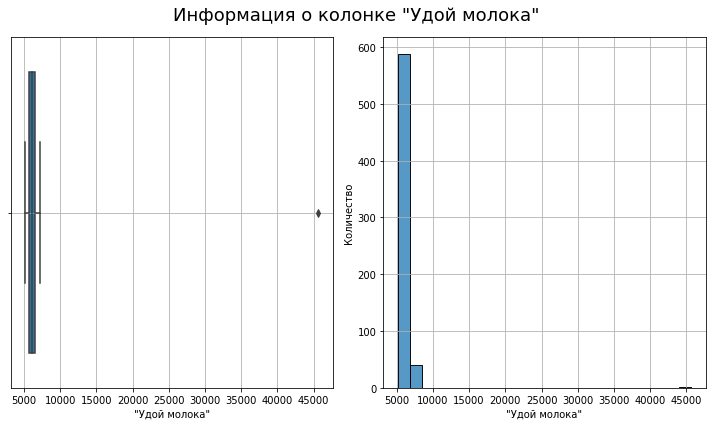

In [54]:
the_basic_plots(ferma_main, 'milk_yield', '"Удой молока"')

Видим, что есть сильные выбросы, посмотрим на них поближе:

In [55]:
ferma_main.query('milk_yield >= 8000')

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
17,45616,11.50,1675,0.93,вис бик айдиал,холмистое,айдиал,3.22,3.08,вкусно,более_2_лет


Удалим эту строку, она сильно помешает дальнейшему исследованию.

In [56]:
ferma_main = ferma_main.loc[ferma_main['milk_yield']<=8000]

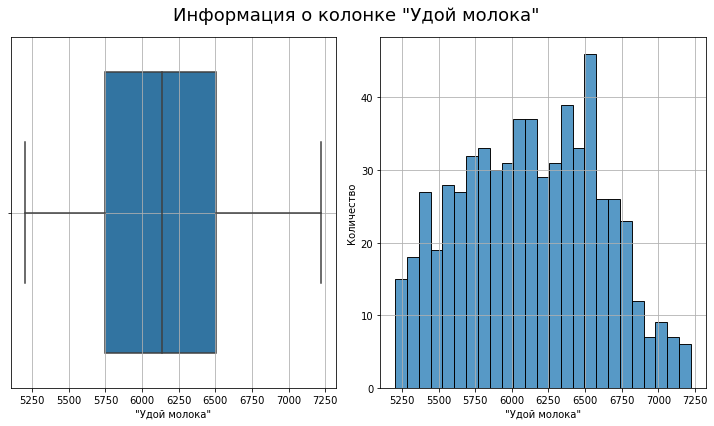

In [57]:
the_basic_plots(ferma_main, 'milk_yield', '"Удой молока"')

In [58]:
ferma_main['milk_yield'].describe()

count    628.00
mean    6125.97
std      475.86
min     5204.00
25%     5749.75
50%     6132.50
75%     6501.00
max     7222.00
Name: milk_yield, dtype: float64

Теперь видим более приемлемое распределение без выбросов, близкое к нормальному. Однако есть пики в конкретных значениях.

3. Столбец *energy_feed_unit*

In [59]:
ferma_main['energy_feed_unit'].describe()

count   628.00
mean     14.55
std       1.30
min      10.90
25%      13.50
50%      14.70
75%      15.60
max      16.80
Name: energy_feed_unit, dtype: float64

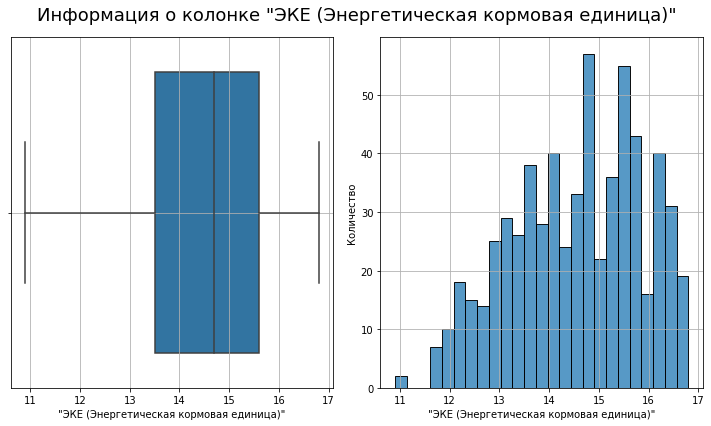

In [60]:
the_basic_plots(ferma_main, 'energy_feed_unit', '"ЭКЕ (Энергетическая кормовая единица)"')

Здесь выбросов не наблюдаем. Про вид распределения сказать явно что-то сложно, много отдельных пиков.

4. Столбец *raw_protein*


In [61]:
ferma_main['raw_protein'].describe()

count    628.00
mean    1923.76
std      182.83
min     1660.00
25%     1771.75
50%     1888.00
75%     2062.25
max     2349.00
Name: raw_protein, dtype: float64

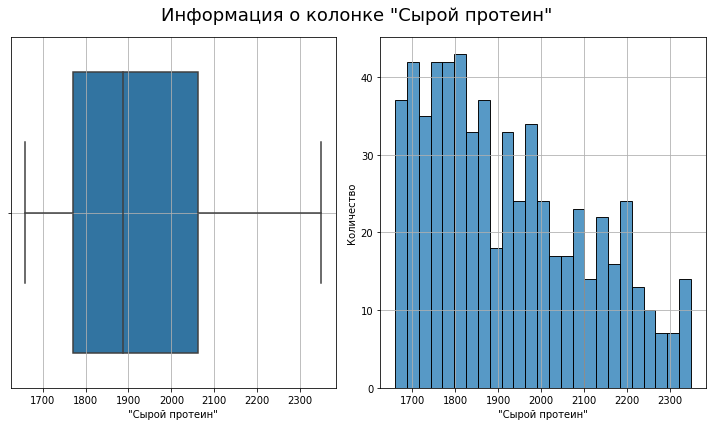

In [62]:
the_basic_plots(ferma_main, 'raw_protein', '"Сырой протеин"')

Выбросов нет. Распределение похоже отдаленно на пуассоновское, однако много конкретных пиковых значений. Видимо, параметр зависит от чего-то еще.

5. Столбец *sugar_protein_ratio*

In [63]:
ferma_main['sugar_protein_ratio'].describe()

count   628.00
mean      0.91
std       0.03
min       0.84
25%       0.89
50%       0.93
75%       0.94
max       0.96
Name: sugar_protein_ratio, dtype: float64

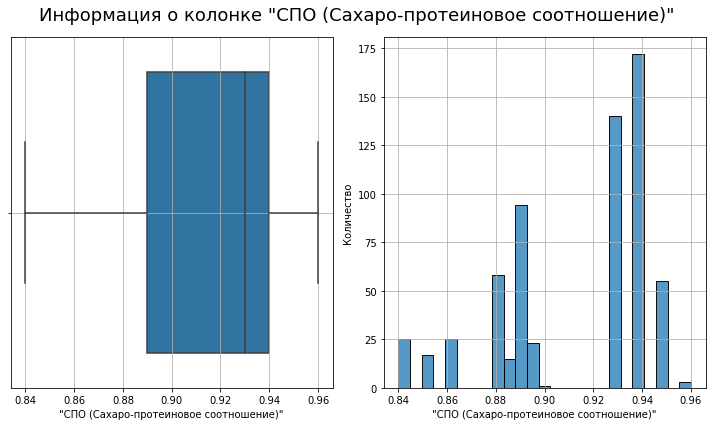

In [64]:
the_basic_plots(ferma_main, 'sugar_protein_ratio', '"СПО (Сахаро-протеиновое соотношение)"')

Видим, что распределение с несколькими явными пиками- мультимодальное. Выбросов явных нет.

6. Столбец *breed*

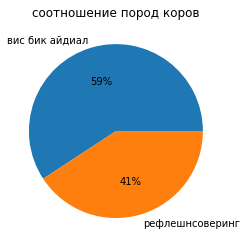

In [65]:
plot_pie_chart(ferma_main['breed'], 'соотношение пород коров')

Коров породы Вис Бик Айдиал почти в 1,5 раза больше коров породы Рефлешнсоверинг

7. Столбец *pasture_type*

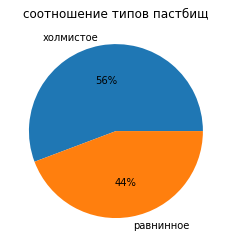

In [66]:
plot_pie_chart(ferma_main['pasture_type'], 'соотношение типов пастбищ')

Холмистых пастбищ чуть больше, чем равнинных.

8. Столбец *breed_of_dad*

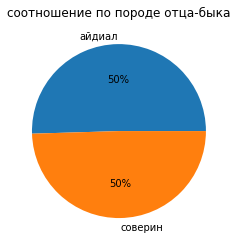

In [67]:
plot_pie_chart(ferma_main['breed_of_dad'], 'соотношение по породе отца-быка')

Ровно пополам, это говорит о том, что в хозяйстве все выверено с определенной точностью и предпочтениями.

9. Столбец *fat_content*

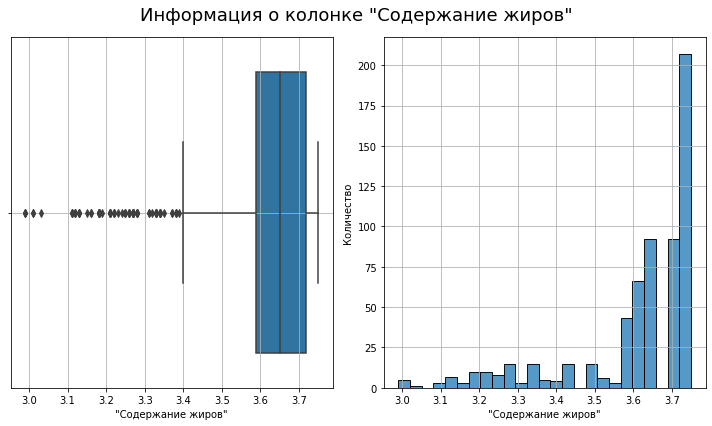

In [68]:
the_basic_plots(ferma_main, 'fat_content', '"Содержание жиров"')

Значения за пределами ящика с усами сложно назвать выбросами, потому что это адекватные значения содержания жиров, но большинство коров обладает жирностью молока > 3,5%.

10. Столбец *protein*

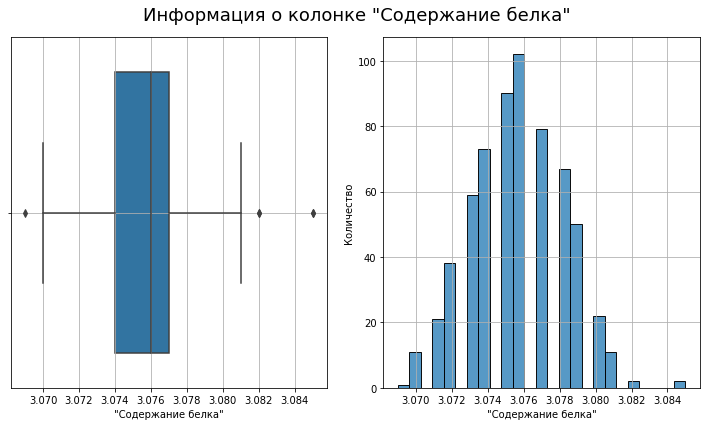

In [69]:
the_basic_plots(ferma_main, 'protein', '"Содержание белка"')

Распределение похоже на нормальное с некоторыми пропусками.

11. Столбец *milk_taste*

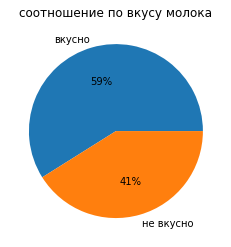

In [70]:
plot_pie_chart(ferma_main['milk_taste'], 'соотношение по вкусу молока')

Большинство коров конечно дает вкусное молоко, но тем не менее, очень много тех, кто не устраивает по вкусу.

12. Столбец *age*

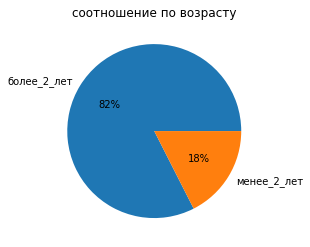

In [71]:
plot_pie_chart(ferma_main['age'], 'соотношение по возрасту')

Большинство коров конечно, старше 2 лет, потому что только они могут давать наиболее качественное молоко.

### <a id='toc3_2_'></a>3.2 Cтатистический анализ признаков *ferma_dad*  [&#8593;](#toc0_)

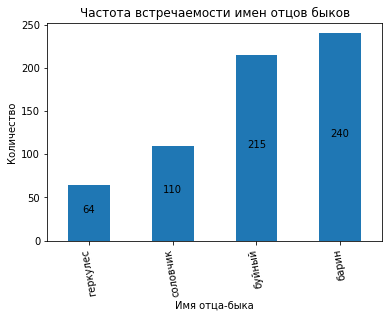

In [72]:
ferma_dad_sorted = ferma_dad['dad_name'].value_counts().sort_values() 

ferma_dad_sorted.plot(kind='bar')
addlabels(ferma_dad_sorted, ferma_dad_sorted, ferma_dad_sorted)
plt.title('Частота встречаемости имен отцов быков')
plt.xlabel('Имя отца-быка')
plt.ylabel('Количество')
plt.xticks(rotation=100)
plt.show()

Буйный и Барин являются отцами бОльшей части коров на ферме (более 2/3)

### <a id='toc3_3_'></a>3.3 Cтатистический анализ признаков *cow_buy*  [&#8593;](#toc0_)

In [73]:
cow_buy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   breed_of_dad  20 non-null     object 
 3   dad_name      20 non-null     object 
 4   fat_content   20 non-null     float32
 5   protein       20 non-null     float32
 6   age           20 non-null     object 
dtypes: float32(2), object(5)
memory usage: 1.1+ KB


1. Столбец *breed*

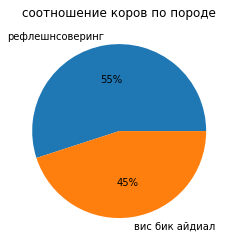

In [74]:
plot_pie_chart(cow_buy['breed'], 'соотношение коров по породе')

По 8 коров каждой породы есть на "ЭкоФерме", которые фермер потенциально рассматривает к покупке.

2. Столбец *pasture_type*

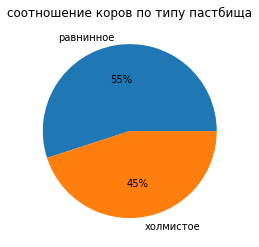

In [75]:
plot_pie_chart(cow_buy['pasture_type'], 'соотношение коров по типу пастбища')

И здесь на две равные части поделились коровы по типу пастбища.

3. Столбец *breed_of_dad*

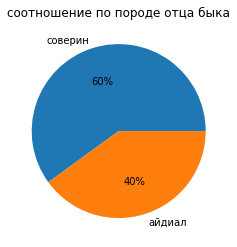

In [76]:
plot_pie_chart(cow_buy['breed_of_dad'], 'соотношение по породе отца быка')

4. Столбец *dad_name*

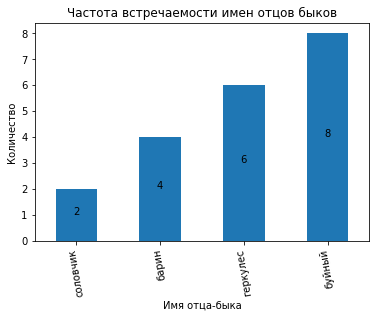

In [77]:
cow_buy_dad_name_sorted = cow_buy['dad_name'].value_counts().sort_values() 

cow_buy_dad_name_sorted.plot(kind='bar')
addlabels(cow_buy_dad_name_sorted, cow_buy_dad_name_sorted, cow_buy_dad_name_sorted)
plt.title('Частота встречаемости имен отцов быков')
plt.xlabel('Имя отца-быка')
plt.ylabel('Количество')
plt.xticks(rotation=100)
plt.show()

В отличиче от уже существующих у фермера коров, в ЭкоФерме коров с отцом Барин меньшинство.

4. Столбец *fat_content*

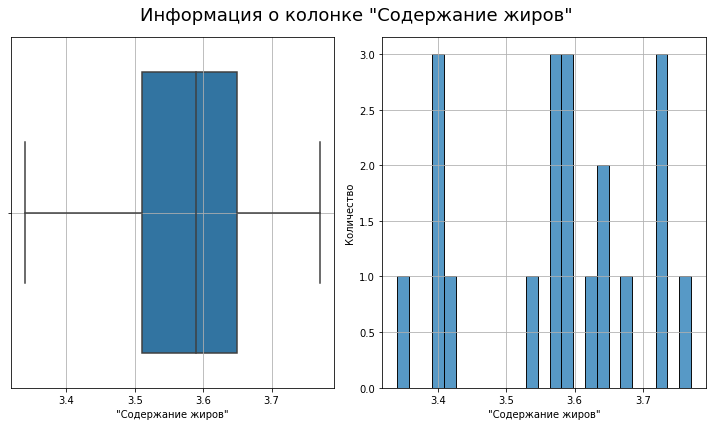

In [78]:
the_basic_plots(cow_buy, 'fat_content', '"Содержание жиров"')

Явных выбросов нет, но из-за небольшого количества данных, что-то говорить о характере распределения сложно.

5. Столбец *protein*

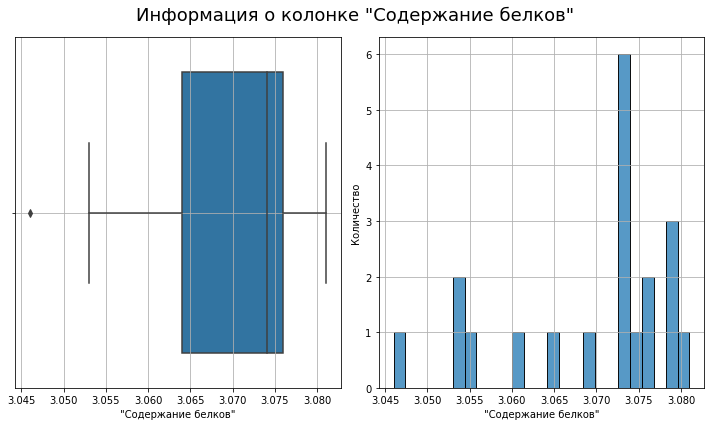

In [79]:
the_basic_plots(cow_buy, 'protein', '"Содержание белков"')

Ситуация аналогичная предыдущей, однако визуальной взаимосвязи между количеством белков и жиров не наблюдается.

6. Столбец *age*

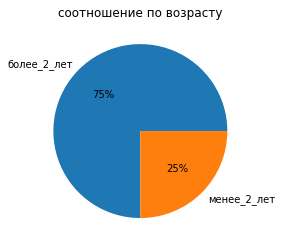

In [80]:
plot_pie_chart(cow_buy['age'], 'соотношение по возрасту')

Как и следовало ожидать, большинство коров старше 2 лет.

Вывод: После визуальной оценки статистических характеристик, можно заметить, что распределения значений в большинстве не похожи на одномодальные нормальные. Числовые данные в дальнейшем придется нормализировать. К категориальным переменным необходимо будет применить кодировку.

## <a id='toc4_'></a> 4 Корреляционный анализ признаков в датасете *ferma_main* [&#8593;](#toc0_)

### <a id='toc4_1_'></a>4.1 Расчет коэффициентов корреляции между признаками   [&#8593;](#toc0_)

<AxesSubplot:>

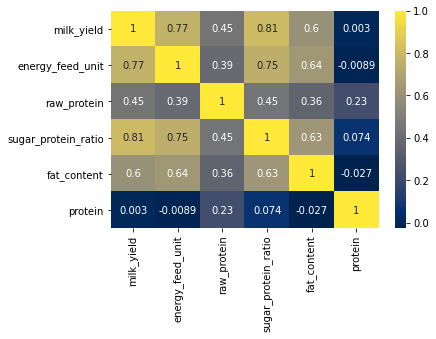

In [81]:
sns.heatmap(ferma_main.corr(), annot=True, cmap='cividis')

<AxesSubplot:>

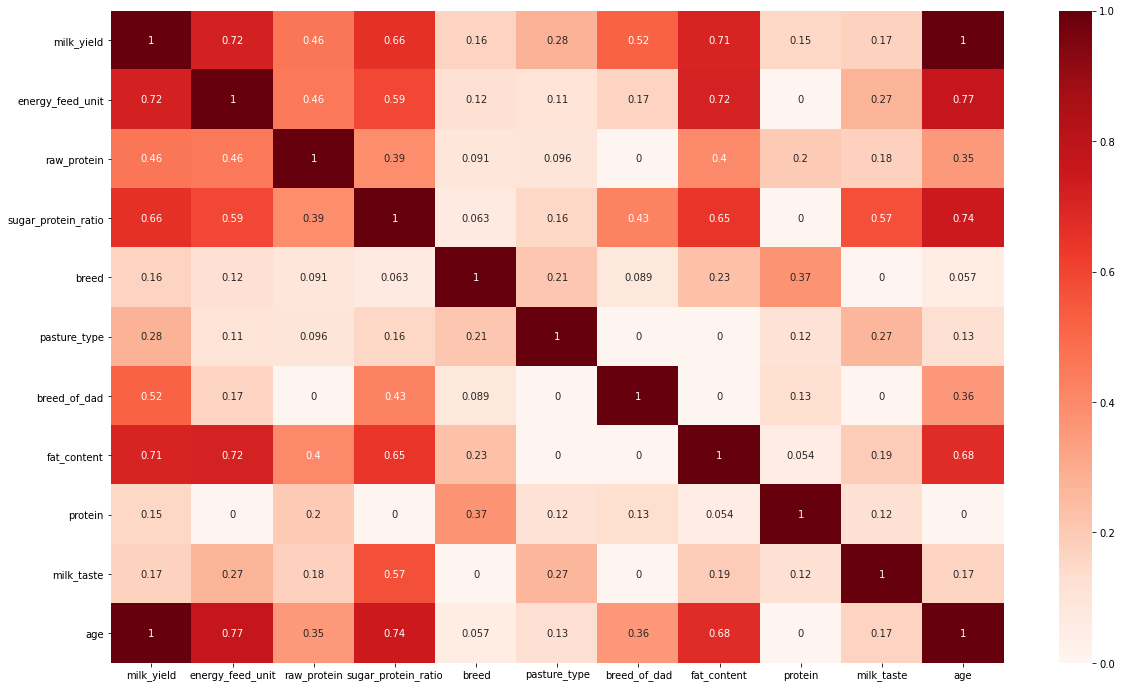

In [82]:
numeric_c_full = ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']
numeric_c = ['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']
categorize_c = ['breed', 'pasture_type', 'breed_of_dad', 'age']

plt.figure(figsize=(20, 12))
phik_corr_matrix = ferma_main.phik_matrix(interval_cols=numeric_c_full)
sns.heatmap(phik_corr_matrix, annot=True, cmap='Reds')

Построим диаграммы рассеяния

### <a id='toc4_2_'></a>4.2 Диаграммы рассеяния для признака *milk_yield*   [&#8593;](#toc0_)

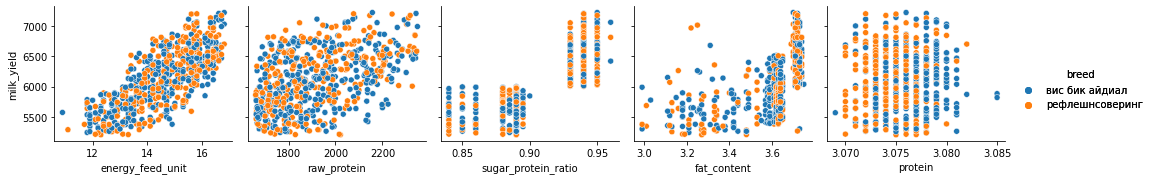

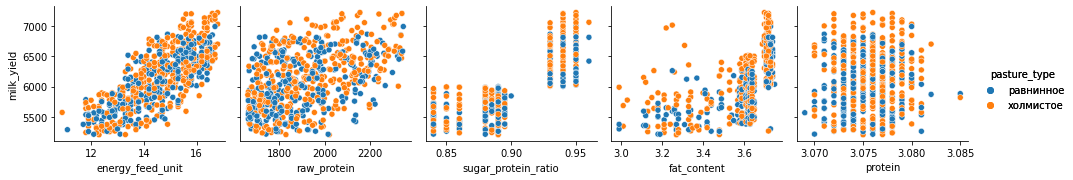

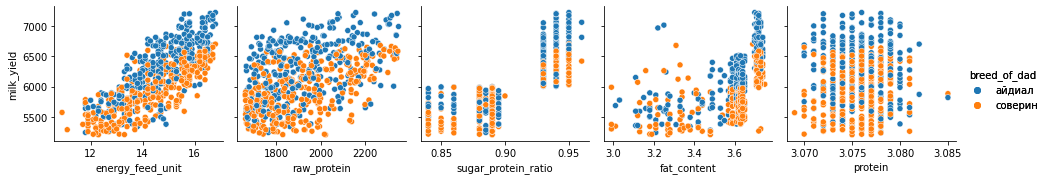

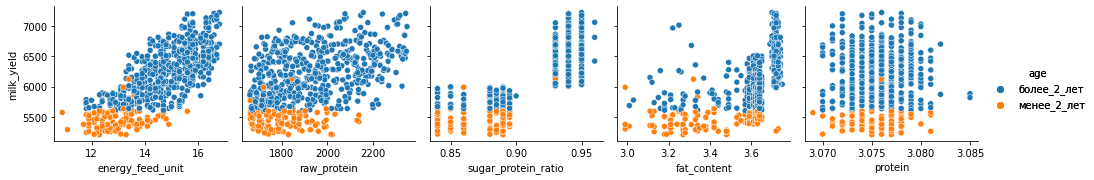

In [83]:
for cat in categorize_c:
    pl = sns.pairplot(data=ferma_main, hue=cat, x_vars=numeric_c, y_vars='milk_yield')
    pl.add_legend()

Можем заметить несколько аспектов взаимосвязи численных данных:

- Кол-во белка почти не коррелируется с остальными признаками
- Удой молока связан с ЭКЕ, СПО и содержанием жиров, что логично
- Взаимосвязь между СПО и ЭКЕ непосредественно так же объясняется возможным наличием общих параметров определения, но назвать это мультиколлинеарностью нельзя( коэффициент корреляции сильно меньше 0,9)
- Вкус молока положительно коррелируется с СПО, но связь несильная

Также стоит заметить, что зависимость целевого признака *удоя молока* от *СПО* и *ЭКЕ* нелинейная. С *ЭКЕ* более похожа на степенную, с *СПО* бинарно разделенная.

## <a id='toc5_'></a> 5 Задача регрессии [&#8593;](#toc0_)

### <a id='toc5_1_'></a>5.1 Первая модель линейной регрессии [&#8593;](#toc0_)

1. Подготовка данных


In [84]:
target_pos = 'milk_yield'

X = ferma_main.drop([target_pos, 'milk_taste'], axis=1)
y = ferma_main[target_pos]

Несмотря на наличие очень слабой корреляции между параметром содержания белков и целевым признаком Удоя, уберем его из рассмотрения. С точки зрения логики продукта на удой количество белков также слабо влияет.

In [85]:
X = X.drop(['protein'], axis=1)

2. Разбиение выборки на тренировочную и тестовую, кодирование и масштабирование признаков

In [86]:
num_cols = ['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio','fat_content']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age']

In [87]:
X_train, X_test, y_train, y_test = proc_split(X, y, num_cols, cat_cols)

3. Обучаем модель на данных

In [88]:
regression_model_1 = LinearRegression()
regression_model_1.fit(X_train, y_train)
predictions_1 = regression_model_1.predict(X_test)

4. Построим диаграммы остатков и рассчитаем метрику $R^2$

In [89]:
r2 = r2_score(y_test, predictions_1)
r2

0.7840492007614903

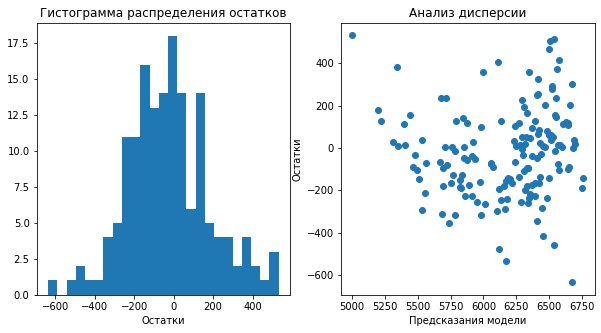

In [90]:
residuals_1 = y_test - predictions_1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1,bins = 25)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1, y=residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод**:Исходя из значения $R^2$ можно отметить, что модель далеко не идеальна и предсказания не точны. Гистограмма распределения остатков похожа на нормальную, с небольшим смещением влево, что говорит о завышении предсказаний. Дисперсия распределена не совсем равномерно, необходимо улучшать модель.

## <a id='toc5_2_'></a>5.2 Вторая модель линейной регрессии [&#8593;](#toc0_)

СПО и Удой связаны нелинейно и разделены на кластеры, преобразуем их в категориальный бинарный признак.

In [91]:
line_clas = 0.92 # порог разделения кластера
X['sugar_protein_ratio_bin'] = (X['sugar_protein_ratio'] <= line_clas).astype('int')
X = X.drop('sugar_protein_ratio', axis=1)

In [92]:
X['sugar_protein_ratio_bin'].value_counts()

0    370
1    258
Name: sugar_protein_ratio_bin, dtype: int64

ЭКЕ и Удой связаны почти квадратично, заменим соответственно значения на их квадраты

In [93]:
X['energy_feed_unit_sq'] = X['energy_feed_unit'] ** 2
X = X.drop('energy_feed_unit', axis=1)

Теперь попробуем заново так же обучить модель

In [94]:
num_cols = ['energy_feed_unit_sq', 'raw_protein', 'sugar_protein_ratio_bin','fat_content']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age']

In [95]:
X_train, X_test, y_train, y_test = proc_split(X, y, num_cols, cat_cols)

In [96]:
regression_model_2 = LinearRegression()
regression_model_2.fit(X_train, y_train)
predictions_2 = regression_model_2.predict(X_test)

In [97]:
r2 = r2_score(y_test, predictions_2)
r2

0.8169746922966723

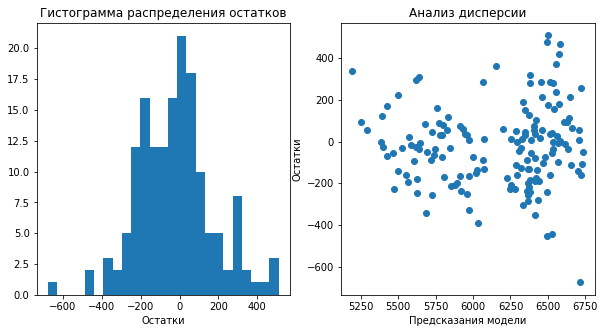

In [98]:
residuals_2 = y_test - predictions_2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2, bins = 25)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_2, y=residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод**: На гистограмме появились некоторые выбросы, но распределение чуть сместилось ближе к 0, похоже на нормальное. Дисперсия опять же не равномерная, на больших значениях удоя она больше. Общая оценка по метрике $R^2$ чуть лучше (на 0,032 примерно).

## <a id='toc5_3_'></a>5.3 Третья модель линейной регрессии [&#8593;](#toc0_)

Добавим имена отцов в датафрейм:


In [99]:
ferma_dad.head()

,dad_name
id,
1,буйный
2,соловчик
3,барин
4,буйный
5,барин


In [100]:
ferma_main.head()

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,вис бик айдиал,равнинное,соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.88,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.88,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.88,вис бик айдиал,равнинное,соверин,3.73,3.07,вкусно,менее_2_лет


In [101]:
X = X.join(ferma_dad, how='left', on='id')

In [102]:
num_cols = ['energy_feed_unit_sq', 'raw_protein','fat_content']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age', 'dad_name', 'sugar_protein_ratio_bin']

In [103]:
X_train, X_test, y_train, y_test = proc_split(X, y, num_cols, cat_cols)

In [104]:
X_test.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,-0.53,0.20,1.00,-0.81,1.00
1,0.00,1.00,1.00,0.00,0.00,1.00,1.49,0.62,1.00,0.03,0.00
2,1.00,1.00,1.00,0.00,0.00,0.00,-0.53,0.14,1.00,-0.68,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,-0.96,0.08,0.00,-1.06,1.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.56,0.08,1.00,-1.41,1.00


In [105]:
regression_model_3 = LinearRegression()
regression_model_3.fit(X_train, y_train)
predictions_3 = regression_model_3.predict(X_test)

In [106]:
r2 = r2_score(y_test, predictions_3)
r2

0.8232607652463259

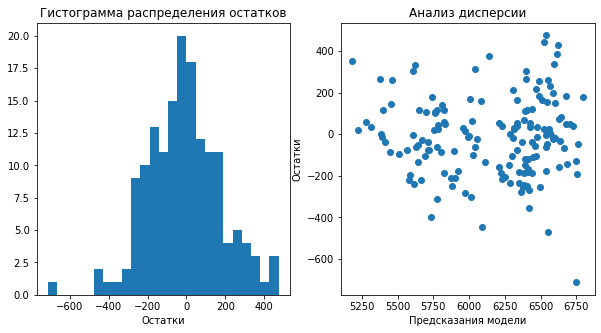

In [107]:
residuals_3 = y_test - predictions_3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3, bins = 25)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_3, y=residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод**: гистограмма остатков не сильно поменялась, однако дисперсия стала чуть более равномерной. Оценка $R^2$ еще лучше у данной модели.

## <a id='toc5_4_'></a>5.4 Сравнение метрик и построение доверительного интервала для лучшей модели [&#8593;](#toc0_)

In [108]:
table_metrics = PrettyTable()
table_metrics.field_names = ['Номер модели','R2', 'MAE', 'MSE', 'RMSE']

In [109]:
table_metrics.add_row([1] + metrics(y_test, predictions_1))
table_metrics.add_row([2] + metrics(y_test, predictions_2))
table_metrics.add_row([3] + metrics(y_test, predictions_3))

print(table_metrics)

+--------------+---------+-----------+-------------+-----------+
| Номер модели |    R2   |    MAE    |     MSE     |    RMSE   |
+--------------+---------+-----------+-------------+-----------+
|      1       | 0.78405 | 163.61997 | 43960.01678 | 209.66644 |
|      2       | 0.81697 | 148.29631 | 37257.54027 | 193.02212 |
|      3       | 0.82326 | 146.56435 | 35977.91605 | 189.67845 |
+--------------+---------+-----------+-------------+-----------+


Явно видно, что по метрикам лучшей является 3-я модель, ее мы и будем использовать для предсказаний удоя коров "ЭкоФермы"

Построим доверительный интервал в 5%, посчитав квантили ошибки модели 3:


In [110]:
low_q = np.quantile(predictions_3, 0.025)
up_q = np.quantile(predictions_3, 0.975)

pred_q = predictions_3[(predictions_3 >= low_q) & (predictions_3 <= up_q)]
print(f'Доверительный интервал: {pred_q.min():.0f} - {pred_q.max():.0f}')

Доверительный интервал: 5376 - 6747


## <a id='toc5_5_'></a>5.5 Прогноз удоя коров, рассматриваемых к покупке [&#8593;](#toc0_)

In [111]:
ferma_main.head()


,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,вис бик айдиал,равнинное,соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.88,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.88,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.88,вис бик айдиал,равнинное,соверин,3.73,3.07,вкусно,менее_2_лет


In [112]:
cols_exch = ['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio']
for col in cols_exch:
    cow_buy[col] = ferma_main[col].mean() * 1.05

In [113]:
cow_buy.head()

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age,energy_feed_unit,raw_protein,sugar_protein_ratio
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет,15.28,2019.95,0.96
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.08,менее_2_лет,15.28,2019.95,0.96
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более_2_лет,15.28,2019.95,0.96
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более_2_лет,15.28,2019.95,0.96
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более_2_лет,15.28,2019.95,0.96


In [114]:
X.head()

,raw_protein,breed,pasture_type,breed_of_dad,fat_content,age,sugar_protein_ratio_bin,energy_feed_unit_sq,dad_name
id,,,,,,,,,
1,1743,вис бик айдиал,равнинное,айдиал,3.58,более_2_лет,1,201.64,буйный
2,2138,вис бик айдиал,равнинное,соверин,3.54,менее_2_лет,1,163.84,соловчик
3,1854,рефлешнсоверинг,холмистое,соверин,3.59,более_2_лет,1,196.00,барин
4,2012,рефлешнсоверинг,холмистое,айдиал,3.40,более_2_лет,1,153.76,буйный
5,1675,вис бик айдиал,равнинное,соверин,3.73,менее_2_лет,1,163.84,барин


In [115]:
line_clas = 0.92 # порог разделения кластера
cow_buy['sugar_protein_ratio_bin'] = (cow_buy['sugar_protein_ratio'] <= line_clas).astype('int')
cow_buy['energy_feed_unit_sq'] = cow_buy['energy_feed_unit'] ** 2
cow_buy = cow_buy.drop(['energy_feed_unit','sugar_protein_ratio'], axis=1)
cow_buy_pr = cow_buy.drop('protein', axis=1)


In [116]:
num_cols = ['energy_feed_unit_sq', 'raw_protein','fat_content']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age', 'dad_name', 'sugar_protein_ratio_bin']

cow_buy_pr_scaled = pd.DataFrame(scaler.transform(cow_buy_pr[num_cols]), columns=num_cols)
cow_buy_pr_ohe = pd.DataFrame(encoder.transform(cow_buy_pr[cat_cols]), columns=encoder.get_feature_names_out())

cow_buy_pr = pd.concat([cow_buy_pr_scaled, cow_buy_pr_ohe], axis=1)
cow_buy_pr = cow_buy_pr.sort_index(axis=1)
cow_buy_pr.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,0.54,-0.16,1.00,0.52,0.00
1,1.00,1.00,0.00,1.00,0.00,0.00,0.54,-0.40,0.00,0.52,0.00
2,0.00,1.00,1.00,0.00,0.00,0.00,0.54,-0.10,0.00,0.52,0.00
3,0.00,0.00,1.00,1.00,0.00,0.00,0.54,-1.24,1.00,0.52,0.00
4,0.00,0.00,1.00,1.00,0.00,0.00,0.54,0.20,0.00,0.52,0.00


In [117]:
X_test.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,-0.53,0.20,1.00,-0.81,1.00
1,0.00,1.00,1.00,0.00,0.00,1.00,1.49,0.62,1.00,0.03,0.00
2,1.00,1.00,1.00,0.00,0.00,0.00,-0.53,0.14,1.00,-0.68,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,-0.96,0.08,0.00,-1.06,1.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.56,0.08,1.00,-1.41,1.00


In [118]:
predictions_milk_yield = regression_model_3.predict(cow_buy_pr)

In [119]:
predictions_milk_yield

array([6592.48710377, 6358.26392416, 6255.47962284, 6538.11164532,
       6530.64851865, 6421.8445606 , 6592.48710377, 6541.31712081,
       6255.47962284, 6361.27401254, 6350.76705163, 6619.40073963,
       6613.20569941, 6086.68223839, 6255.47962284, 6538.11164532,
       6350.76705163, 6450.85052534, 6493.66441506, 6530.64851865])

Получили значения 20 позиций удоя молока для каждой коровы, рассматриваемой к покупке фермером.

## <a id='toc6_'></a> 6 Задача классификации [&#8593;](#toc0_)

## <a id='toc6_1_'></a>6.1 Модель логистической регрессии [&#8593;](#toc0_)

Добавим столбцы, которые могут влиять на вкус молока:

In [120]:
X = X.join([ferma_main['protein']]).sort_index(axis=1)


In [121]:
ferma_main.head()


,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,breed_of_dad,fat_content,protein,milk_taste,age
id,,,,,,,,,,,
1,5863,14.20,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.08,вкусно,более_2_лет
2,5529,12.80,2138,0.89,вис бик айдиал,равнинное,соверин,3.54,3.08,вкусно,менее_2_лет
3,5810,14.00,1854,0.88,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более_2_лет
4,5895,12.40,2012,0.88,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более_2_лет
5,5302,12.80,1675,0.88,вис бик айдиал,равнинное,соверин,3.73,3.07,вкусно,менее_2_лет


In [122]:
X.head()

,age,breed,breed_of_dad,dad_name,energy_feed_unit_sq,fat_content,pasture_type,protein,raw_protein,sugar_protein_ratio_bin
id,,,,,,,,,,
1,более_2_лет,вис бик айдиал,айдиал,буйный,201.64,3.58,равнинное,3.08,1743,1
2,менее_2_лет,вис бик айдиал,соверин,соловчик,163.84,3.54,равнинное,3.08,2138,1
3,более_2_лет,рефлешнсоверинг,соверин,барин,196.00,3.59,холмистое,3.07,1854,1
4,более_2_лет,рефлешнсоверинг,айдиал,буйный,153.76,3.40,холмистое,3.08,2012,1
5,менее_2_лет,вис бик айдиал,соверин,барин,163.84,3.73,равнинное,3.07,1675,1


In [123]:
target_pos = 'milk_taste'
y = ferma_main[target_pos]

In [124]:
num_cols = ['raw_protein','fat_content','protein','energy_feed_unit_sq']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age','sugar_protein_ratio_bin','dad_name']

In [125]:
X_train, X_test, y_train, y_test = proc_split(X, y, num_cols, cat_cols)

In [126]:
y_train = (y_train == 'вкусно').astype(int)
y_test = (y_test == 'вкусно').astype(int)
y_test[:5]

id
583    1
593    1
552    1
215    0
487    1
Name: milk_taste, dtype: int64

In [127]:
y_train[:5]

id
509    1
384    1
588    0
198    1
329    1
Name: milk_taste, dtype: int64

In [128]:
clf_1 = LogisticRegression(random_state=0)
clf_1 = clf_1.fit(X_train, y_train)
y_pred= clf_1.predict(X_test)
clf_1.coef_

array([[-0.20213126, -0.03745247,  0.04049815, -0.09482437, -0.10017183,
        -0.42276689,  0.61533174, -0.0205315 ,  0.50172082,  0.2617441 ,
         0.17006199,  0.71868672]])

In [129]:
confusion = np.zeros((2, 2)).astype(np.int64)
for i in range(2):
   for j in range(2):
            confusion[i][j] = np.sum(np.logical_and(y_test == i, y_pred == j))
confusion

array([[23, 46],
       [12, 76]])

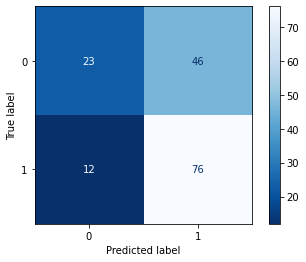

In [130]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues_r')


In [131]:
acc_1 = accuracy_score(y_test,y_pred)
acc_1

0.6305732484076433

In [132]:
prec_1 = precision_score(y_test,y_pred)
prec_1

0.6229508196721312

In [133]:
rec_1 = recall_score(y_test,y_pred)
rec_1

0.8636363636363636

Пока модель далека от идеальной, это видно по матрице ошибок и значениям метрик.


## <a id='toc6_2_'></a>6.2 Анализ модели логистической регрессии. Улучшение метрик [&#8593;](#toc0_)

Исходя из результатов выше и что фермеру главное, чтобы молоко было вкусным, то необходимо минимизировать ЛожноПоложительные(FP) значения и использовать метрику *precision* в качестве основополагающей, которую мы будем сводить к значению 1.

Изменим порог принадлежности к классам, для чего исследуем изменения значений метрики *presicion* :

In [134]:
y_pred_proba = clf_1.predict_proba(X_test)[:,1]

table_prec_rec = PrettyTable()
table_prec_rec.field_names = ['threshold', 'precision']

thresholds = [round(i,2) for i in np.linspace(0.01,1.01,num = 100,endpoint=False)]
precisions = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = round(precision_score(y_test, y_pred, zero_division=1), 2)
    precisions.append(precision)
    table_prec_rec.add_row([threshold, precision])

print(table_prec_rec)

+-----------+-----------+
| threshold | precision |
+-----------+-----------+
|    0.01   |    0.56   |
|    0.02   |    0.56   |
|    0.03   |    0.56   |
|    0.04   |    0.56   |
|    0.05   |    0.56   |
|    0.06   |    0.56   |
|    0.07   |    0.56   |
|    0.08   |    0.56   |
|    0.09   |    0.56   |
|    0.1    |    0.56   |
|    0.11   |    0.56   |
|    0.12   |    0.56   |
|    0.13   |    0.56   |
|    0.14   |    0.56   |
|    0.15   |    0.56   |
|    0.16   |    0.56   |
|    0.17   |    0.56   |
|    0.18   |    0.56   |
|    0.19   |    0.56   |
|    0.2    |    0.56   |
|    0.21   |    0.56   |
|    0.22   |    0.56   |
|    0.23   |    0.56   |
|    0.24   |    0.56   |
|    0.25   |    0.56   |
|    0.26   |    0.56   |
|    0.27   |    0.56   |
|    0.28   |    0.56   |
|    0.29   |    0.56   |
|    0.3    |    0.56   |
|    0.31   |    0.57   |
|    0.32   |    0.57   |
|    0.33   |    0.58   |
|    0.34   |    0.57   |
|    0.35   |    0.57   |
|    0.36   

Видим, что минимиация ошибки *FP* первого рода достигается при пороге принадлежности к классу - **0,81**. Построим еще раз матрицу ошибок и рассчитаем метрики *precision* и *recall*

In [135]:
threshold = 0.81
y_pred = y_pred_proba >= threshold


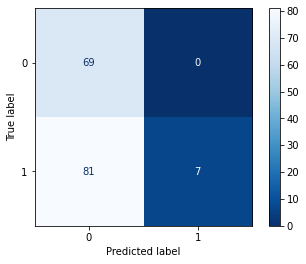

In [136]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues_r')

In [137]:
prec_2 = precision_score(y_test, y_pred)
prec_2

1.0

In [138]:
rec_2 = recall_score(y_test, y_pred)
rec_2

0.07954545454545454

## <a id='toc6_3_'></a>6.3 Прогноз вкуса молока коров, рассматриваемых к приобретению[&#8593;](#toc0_)

In [139]:
cow_buy['protein']

0    3.08
1    3.08
2    3.07
3    3.06
4    3.07
5    3.05
6    3.08
7    3.08
8    3.07
9    3.08
10   3.06
11   3.07
12   3.05
13   3.08
14   3.07
15   3.07
16   3.08
17   3.05
18   3.07
19   3.07
Name: protein, dtype: float32

In [140]:
cow_buy_pr_class = cow_buy
cow_buy_pr_class.head()

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age,raw_protein,sugar_protein_ratio_bin,energy_feed_unit_sq
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет,2019.95,0,233.36
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.08,менее_2_лет,2019.95,0,233.36
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более_2_лет,2019.95,0,233.36
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более_2_лет,2019.95,0,233.36
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более_2_лет,2019.95,0,233.36


In [141]:
num_cols = ['raw_protein','fat_content','protein','energy_feed_unit_sq']
cat_cols = ['breed', 'pasture_type', 'breed_of_dad', 'age','sugar_protein_ratio_bin','dad_name']

cow_buy_pr_class = cow_buy

cow_buy_pr_class_scaled = pd.DataFrame(scaler.transform(cow_buy_pr_class[num_cols]), columns=num_cols)
cow_buy_pr_class_ohe = pd.DataFrame(encoder.transform(cow_buy_pr_class[cat_cols]), columns=encoder.get_feature_names_out())

cow_buy_pr_class = pd.concat([cow_buy_pr_class_scaled, cow_buy_pr_class_ohe], axis=1)
cow_buy_pr_class = cow_buy_pr_class.sort_index(axis=1)
cow_buy_pr_class.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,protein,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,0.54,-0.16,1.00,0.09,0.52,0.00
1,1.00,1.00,0.00,1.00,0.00,0.00,0.54,-0.40,0.00,2.03,0.52,0.00
2,0.00,1.00,1.00,0.00,0.00,0.00,0.54,-0.10,0.00,-0.68,0.52,0.00
3,0.00,0.00,1.00,1.00,0.00,0.00,0.54,-1.24,1.00,-5.71,0.52,0.00
4,0.00,0.00,1.00,1.00,0.00,0.00,0.54,0.20,0.00,-0.68,0.52,0.00


In [142]:
X_test.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,protein,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,-0.53,0.20,1.00,0.09,-0.81,1.00
1,0.00,1.00,1.00,0.00,0.00,1.00,1.49,0.62,1.00,-1.07,0.03,0.00
2,1.00,1.00,1.00,0.00,0.00,0.00,-0.53,0.14,1.00,0.09,-0.68,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,-0.96,0.08,0.00,-0.68,-1.06,1.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.56,0.08,1.00,0.09,-1.41,1.00


In [143]:
cow_buy_pr_class.head()

,age_менее_2_лет,breed_of_dad_соверин,breed_рефлешнсоверинг,dad_name_буйный,dad_name_геркулес,dad_name_соловчик,energy_feed_unit_sq,fat_content,pasture_type_холмистое,protein,raw_protein,sugar_protein_ratio_bin_1
0,0.00,0.00,0.00,0.00,1.00,0.00,0.54,-0.16,1.00,0.09,0.52,0.00
1,1.00,1.00,0.00,1.00,0.00,0.00,0.54,-0.40,0.00,2.03,0.52,0.00
2,0.00,1.00,1.00,0.00,0.00,0.00,0.54,-0.10,0.00,-0.68,0.52,0.00
3,0.00,0.00,1.00,1.00,0.00,0.00,0.54,-1.24,1.00,-5.71,0.52,0.00
4,0.00,0.00,1.00,1.00,0.00,0.00,0.54,0.20,0.00,-0.68,0.52,0.00


In [144]:
predictions_milk_taste_proba = clf_1.predict_proba(cow_buy_pr_class)[:,1]

In [145]:
threshold = 0.81
predictions_milk_taste = (predictions_milk_taste_proba>= threshold).astype(int)

In [146]:
predictions_milk_taste

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Ни одной коровы со вкусным молоком среди 20, рассматриваемых к покупке.

## <a id='toc6_4_'></a>6.4 Выбор подходящих к покупке коров[&#8593;](#toc0_)

1. Добавим спрогнозированные столбцы и получим итоговую таблицу:

In [147]:
cow_buy_full_pred = cow_buy.join([
    pd.Series(predictions_milk_yield, name='milk_yield'),
    pd.Series(predictions_milk_taste, name='milk_taste')])

In [148]:
cow_buy_full_pred.head()

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age,raw_protein,sugar_protein_ratio_bin,energy_feed_unit_sq,milk_yield,milk_taste
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет,2019.95,0,233.36,6592.49,0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.08,менее_2_лет,2019.95,0,233.36,6358.26,0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более_2_лет,2019.95,0,233.36,6255.48,0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более_2_лет,2019.95,0,233.36,6538.11,0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более_2_лет,2019.95,0,233.36,6530.65,0


2. Отберем коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко:

In [149]:
cow_buy_full_pred.loc[(cow_buy_full_pred['milk_yield']>=6000) & (cow_buy_full_pred['milk_taste']==1)]

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age,raw_protein,sugar_protein_ratio_bin,energy_feed_unit_sq,milk_yield,milk_taste


Как мы видим, к покупке фермеру нельзя порекомендовать ни одной коровы. 

Добавим столбец с предсказанными вероятностями принадлежности к классу "Вкусное молоко" и отберем наиболее удачные для покупки варианты:

In [150]:
cow_buy_full_pred.join(pd.Series(predictions_milk_taste_proba, name='probability_of_taste_milk'))\
    .sort_values(by=['probability_of_taste_milk', 'milk_yield'], ascending=False)\
    .iloc[:3]

,breed,pasture_type,breed_of_dad,dad_name,fat_content,protein,age,raw_protein,sugar_protein_ratio_bin,energy_feed_unit_sq,milk_yield,milk_taste,probability_of_taste_milk
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.08,менее_2_лет,2019.95,0,233.36,6361.27,0,0.74
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет,2019.95,0,233.36,6592.49,0,0.71
6,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.08,более_2_лет,2019.95,0,233.36,6592.49,0,0.71


Видим, что наиболее удачные варианты (наименее рисковые), на которые стоит обратить внимание фермеру, обладают довольно высокими показателями по удою, но не дотягивают до уровня порога принадлежности к классу "Вкусное молоко" в пределах 0,1. 

Стоит отметить, что у них есть схожие параметры: тип пастбища и порода отца-быка. Именно на эти параметры стоит обратить внимание фермеру в будущем.

# <a id='toc6_'></a> 7. Итоговые выводы[&#8593;](#toc0_)

В ходе проекта были рассмотрены и исследованы следующие пункты:
1. Подготовка данных. В ходе которой были обнаружены некоторые проблемы в типах данных и названий столбцов.

2. Предобработка данных: 
- Были обработаны пропущенные значения, которых не оказалось, и дубликаты, среди которых были неявные.
- Скорректировали типы данных, устранили некоторые проблемы.

3. Исследовательский анализ данных: был проведен статистический анализ данных, в ходе которого мы исследовали каждый признак, благодаря чему смогли выявить некоторые закономерности и улучшить данные, также были удалены выбросы в данных.

4. Корреляционный анализ признаков в датасете: бы произведен расчет коэффициентов корреляции признаков, построены диаграммы рассеяния зависимости целевого признака, получены такие выводы о взаимосвязях данных:
- Кол-во белка почти не коррелируется с остальными признаками
- Удой молока связан с ЭКЕ, СПО и содержанием жиров, что логично
- Взаимосвязь между СПО и ЭКЕ непосредественно так же объясняется возможным наличием общих параметров определения, но назвать это мультиколлинеарностью нельзя( коэффициент корреляции сильно меньше 0,9)
- Вкус молока положительно коррелируется с СПО, но связь несильная
- Зависимость целевого признака *удоя молока* от *СПО* и *ЭКЕ* нелинейная. С *ЭКЕ* более похожа на степенную, с *СПО* бинарно разделенная.

5. Задача регрессии. Обучены три модели линейной регрессии:
- Первая модель была обучена на исходных данных с выбранными входными признаками
- Во второй модели признак *СПО* был преобразован в бинарный. Признак *ЭКЕ* был возведен в квадрат для получения относительно линейной зависимости.
- В третьей модели добавили столбец с информацией о именах отцов-быков, что дало наиболее достойные результаты в прогнозах. 

Были рассчитаны метрики оценки качества моделей (*$R^2$*, *MSE*, *RMSE*), где третья показала наиболее приемлемые результаты. Третьей моделью и был осуществлен прогноз удоя молока для рассматриваемых к покупке коров ЭкоФермы.


6. Задача классификации: после подготовки данных обучили проанализировали модель классификации. Далее, основываясь на предпочтениях фермера(минимизировать ложноположительные предсказания-ошибки первого рода), выбрали метрику *precision* для установки правильного порога принадлежности к классам и предсказали с учетом этого вкус молока коров, рассматриваемых к покупке.
Однако метрики *recall* и *accuracy* так же могут быть не менее важны при экномическиъ расчетах и анализе рисков, здесь все зависит от конкретных целях исследования.

В полученных предсказанных данных увидели, что ни одна корова, рассматриваемая к покупке, не обладает качеством "вкусного молока", а значит и полностью подходящих для покупки коров нет. Наименее рисковые варианты коров, на которые стоит обратить внимание фермеру, обладают довольно высокими показателями по удою, но не дотягивают до уровня порога принадлежности к классу "Вкусное молоко" в пределах 0,1. И у них есть схожие параметры: тип пастбища и порода отца-быка. Именно на эти параметры стоит обратить внимание фермеру в будущем.

Рекомендации по улучшению модели линейной регрессии:
Для еще более точных прогнозов и улучшения модели можно тщательнее исследовать признаки для получения более четких линейных зависимостей (это могут быть и операторные преобразования и структурные).
